In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [512]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [513]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [514]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [515]:
def plot_initial_route(dp, delivary_loc, obstacles, route):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")

## Calculate DP

In [516]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [517]:
def create_route(pts, extra):
    idx = 0
    k = len(pts)
    for i in range(k):
        pts.insert(idx, extra)
        idx +=2

    return pts

## Distance Calculate

In [518]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [519]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [520]:
from shapely.geometry import LineString, Polygon, Point

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [521]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Main

In [522]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 5

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

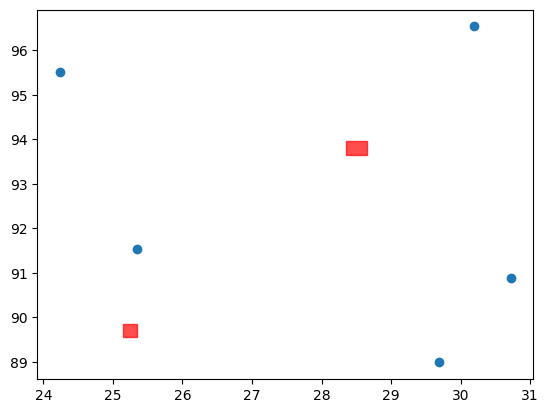

In [523]:
# creating obstacles
obstacles = {
    0 : [[28.35, 93.65],[28.65, 93.95]],
    1 : [[25.15, 89.55],[25.35, 89.85]]
}

primary_plot(delivary_loc, obstacles)

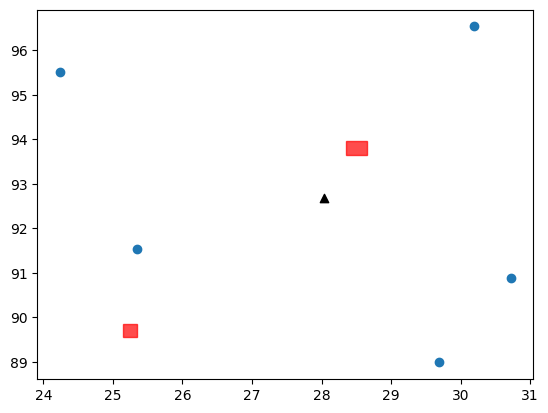

In [524]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [525]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[28.037942825070537, 92.68789283577016] -> [29.69007567693105, 88.98349817378894] -> [28.037942825070537, 92.68789283577016] -> [30.723641225568763, 90.88259568098952] -> [28.037942825070537, 92.68789283577016] -> [30.191729840031826, 96.53452380550864] -> [28.037942825070537, 92.68789283577016] -> [24.239745855417564, 95.50923638980508] -> [28.037942825070537, 92.68789283577016] -> [25.344521527403487, 91.5296101287586] -> End


Initial Distance : 35.796207899016416


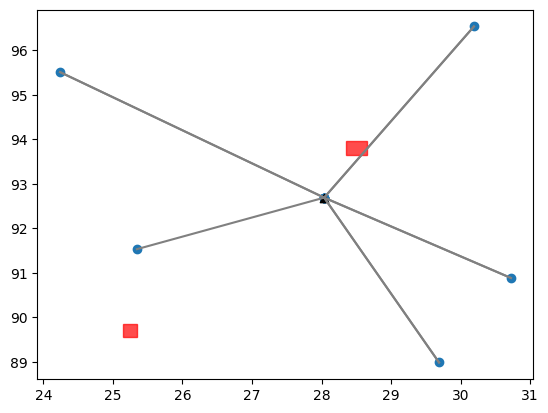

In [526]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

In [527]:
import math

def calculate_angle(point_a, point_b):
    dx = point_b[0] - point_a[0]
    dy = point_b[1] - point_a[1]
    return math.degrees(math.atan2(dy, dx))

In [528]:
def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, points in obstacles.items():
        pt1 = points[0]
        pt2 = points[1]
        coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
        obstacle = Polygon(coord)
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A and B
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        dist_to_b = math.sqrt(((inter.x - point_b[0]) ** 2) + ((inter.y - point_b[1]) ** 2))
        distances[inter] = dist_to_a + dist_to_b

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    # Check if there's a clear path along either side of the obstacle
    left_side = LineString([point_a, Point(nearest_inter.x - 0.5, nearest_inter.y)])
    right_side = LineString([point_a, Point(nearest_inter.x + 0.5, nearest_inter.y)])
    if not (left_side.intersects(obstacle) or right_side.intersects(obstacle)):
        # Choose the side that leads closer to B
        if left_side.distance(Point(point_b[0], point_b[1])) < right_side.distance(Point(point_b[0], point_b[1])):
            new_point = Point(nearest_inter.x - 0.5, nearest_inter.y)
        else:
            new_point = Point(nearest_inter.x + 0.5, nearest_inter.y)
        return [new_point.x, new_point.y]

    # If no clear path on either side, find the nearest corner of the obstacle
    obstacle_corners = [points[0], points[1], points[2], points[3]]
    nearest_corner = min(obstacle_corners, key=lambda corner: math.sqrt(((corner[0] - nearest_inter.x) ** 2) + ((corner[1] - nearest_inter.y) ** 2)))

    # Check if both offset points along the y-axis are not inside the obstacle
    sol_1 = Point([nearest_corner[0], nearest_corner[1] + 0.5])
    sol_2 = Point([nearest_corner[0], nearest_corner[1] - 0.5])
    if not (sol_1.intersects(obstacle) and sol_2.intersects(obstacle)):
        # Choose the offset point closer to B
        if sol_1.distance(Point(point_b[0], point_b[1])) < sol_2.distance(Point(point_b[0],point_b[1])):
            return [sol_1.x, sol_1.y]
        else:
            return [sol_2.x, sol_2.y]

    # If no acceptable solution found, return None
    return None

In [529]:
def adv_route(route, dp, obstacles):
    for i in range(len(route)):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            route.insert(i+1, find_inter_point(route[i], route[i+1], obstacles))
    return route

[[28.037942825070537, 92.68789283577016], [29.69007567693105, 88.98349817378894], [28.037942825070537, 92.68789283577016], [30.723641225568763, 90.88259568098952], [28.037942825070537, 92.68789283577016], [29.076641216889588, 93.65], [30.191729840031826, 96.53452380550864], [28.037942825070537, 92.68789283577016], [24.239745855417564, 95.50923638980508], [28.037942825070537, 92.68789283577016], [25.344521527403487, 91.5296101287586]]
11
Its not the optimal solution
Optimal dp : []
Optimal route : []


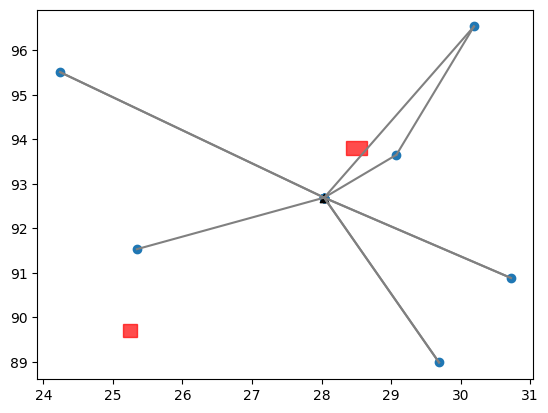

In [530]:
if(detect_obstacle(initial_route, obstacles)):
    new_route = adv_route(initial_route, initial_dp, obstacles)
    print(new_route)
    print(len(new_route))
    plot_initial_route(initial_dp,delivary_loc, obstacles, new_route)

    print("Its not the optimal solution")
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

In [531]:
import math

def calculate_angle(point_a, point_b):
    dx = point_b[0] - point_a[0]
    dy = point_b[1] - point_a[1]
    return math.degrees(math.atan2(dy, dx))

In [532]:
def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, points in obstacles.items():
        pt1 = points[0]
        pt2 = points[1]
        coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
        obstacle = Polygon(coord)
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A and B
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        dist_to_b = math.sqrt(((inter.x - point_b[0]) ** 2) + ((inter.y - point_b[1]) ** 2))
        distances[inter] = dist_to_a + dist_to_b

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    # Check if there's a clear path along either side of the obstacle
    left_side = LineString([point_a, Point(nearest_inter.x - 0.5, nearest_inter.y)])
    right_side = LineString([point_a, Point(nearest_inter.x + 0.5, nearest_inter.y)])
    if not (left_side.intersects(obstacle) or right_side.intersects(obstacle)):
        # Choose the side that leads closer to B
        if left_side.distance(Point(point_b[0], point_b[1])) < right_side.distance(Point(point_b[0], point_b[1])):
            new_point = Point(nearest_inter.x - 0.5, nearest_inter.y)
        else:
            new_point = Point(nearest_inter.x + 0.5, nearest_inter.y)
        return [new_point.x, new_point.y]

    # If no clear path on either side, find the nearest corner of the obstacle
    obstacle_corners = [points[0], points[1], points[2], points[3]]
    nearest_corner = min(obstacle_corners, key=lambda corner: math.sqrt(((corner[0] - nearest_inter.x) ** 2) + ((corner[1] - nearest_inter.y) ** 2)))

    # Check if both offset points along the y-axis are not inside the obstacle
    sol_1 = Point([nearest_corner[0], nearest_corner[1] + 0.5])
    sol_2 = Point([nearest_corner[0], nearest_corner[1] - 0.5])
    if not (sol_1.intersects(obstacle) and sol_2.intersects(obstacle)):
        # Choose the offset point closer to B
        if sol_1.distance(Point(point_b[0], point_b[1])) < sol_2.distance(Point(point_b[0],point_b[1])):
            return [sol_1.x, sol_1.y]
        else:
            return [sol_2.x, sol_2.y]

    # If no acceptable solution found, return None
    return None

print(find_inter_point([26.12,87.34],[30.45,99.67],obstacles))
print(obstacles)

[28.941273317112735, 93.95]
{0: [[28.35, 93.65], [28.65, 93.95]], 1: [[25.15, 89.55], [25.35, 89.85]]}
